#### Input data
Define standards absorbance and concentration

Define unknown absorbances

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd


input_fname = 'micro_BCA_LB_data_0.xlsx' 
input_sheet = '091825'

output_fname = f'BCA_output_{input_sheet}.xlsx'
output_sheet_lb = f'C_lb_{input_sheet}'

# Read in the row data from Excel
df = pd.read_excel(input_fname, input_sheet)

# Show the first few rows of the data
print(df.head())

# data is read in as np.ndarray
#### standards
C_std   = df.iloc[0, 1:].values  # (row 1, all columns but first)
A_std0  = df.iloc[1, 1:].values  
# loosely-bound (lb) 
## 091825 ##
A0 = df.iloc[4:8, 1:].values  # rows 4-7
names = df.iloc[3, 1:].values

# define the blank
blank  = A_std0[5]*np.ones(6,)

# subtract blank
A_std  = np.subtract(A_std0,blank)
A = np.subtract(A0,blank)

# convert to numeric 
C_std  = pd.to_numeric(C_std, errors='coerce') 
A_std  = pd.to_numeric(A_std, errors='coerce') 
A      = np.vectorize(lambda x: pd.to_numeric(x, errors='coerce'))(A)

# detection limit
lower_limit = 2  # ug/mL
upper_limit = 40

# flag to force line of best fit to intersect zero
force_zero = 1

      Unnamed: 0  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0  Concentration      40.000      20.000      10.000       4.000       2.000   
1     Absorbance       0.769       0.469       0.302       0.208       0.127   
2            NaN         NaN         NaN         NaN         NaN         NaN   
3          Names      40.000      20.000      14.000      10.000       7.000   
4            A-1       0.689       0.648       0.429       0.426       0.469   

   Unnamed: 6  
0       0.000  
1       0.099  
2         NaN  
3       5.000  
4       0.321  


In [119]:
print(A)
print(type(names))


[[0.59  0.549 0.33  0.327 0.37  0.222]
 [0.535 0.585 0.418 0.371 0.354 0.355]
 [0.433 0.431 0.267 0.218 0.151 0.172]
 [0.448 0.517 0.351 0.357 0.34  0.198]]
<class 'numpy.ndarray'>


#### Fit a 3rd degree polynomial to the data

3rd degree polynomial (Source: How to use a protein assay standard curve)

https://assets.thermofisher.com/TFS-Assets/LSG/Application-Notes/TR0057-Read-std-curves.pdf

We need a formula to solve for concentration given absorbance.

Formula Structure:  
x = A + By + Cy<sup>2</sup> + Dy<sup>3</sup>

where x is protein concentration and y is absorbance

I want the line to intersect the origin, and so I want the constant A to equal 0.  I can force this.  I expected that changing this would alter the R-squared value, but it is not.

Then, use the fit line to solve for the concentration of the unknown samples.

Coding Resources:

This example was useful in understanding polyfit: 
https://stackoverflow.com/questions/18767523/fitting-data-with-numpy

In [120]:
# fit the standards 
coefs = poly.polyfit(A_std, C_std, 3)  # 3rd deg polynomial

# This forces the fit line to intersect (0,0)
if force_zero == 1:
    coefs[0] = 0
    
# create line of best fit 
C_fit = poly.polyval(A_std, coefs)  # [ug/mL]
print('coefficients: ', coefs, '\n')

# function to determine concentration of unknown samples
def solve_conc(y):
    return poly.polyval(y, coefs)

# determine concentration of unknown samples [ug protein/mL buffer]
C = solve_conc(A)
print('concentration[ug/mL]: ', C)

coefficients:  [  0.          31.58224284  80.60084692 -58.85042968] 

concentration[ug/mL]:  [[34.60403569 31.89389666 17.08466448 16.88821002 19.73873498 10.33970467]
 [30.95468896 34.27728525 22.98616041 19.8058072  18.66997494 18.73651592]
 [24.00924438 23.87269917 13.05824394 10.10569948  6.40407943  7.51718387]
 [25.03419772 29.73929184 18.47057062 18.86970509 17.74236318  8.95633958]]


#### Solve for R-squared
This applies to the standard data 

This resource showed me how to calculate R-squared: 
https://www.askpython.com/python/coefficient-of-determination

In [121]:
# How good is the fit?
# Solve for the coefficient of determination (R-squared)
corr_matrix = np.corrcoef(C_std, C_fit)  # (actual, predict)
corr = corr_matrix[0,1]
R_sq = corr**2
print('R^2: ', R_sq)

R^2:  0.9989219529627611


#### Verify the samples are within the concentration range of the standards

Plot the standards against the unknown data 

Use concontration units for the standards (not in terms of VSS)

In [122]:
# check lower limit
if np.any(C < lower_limit) == True:
    print('WARNING: Some LB concentrations are lower than the lower limit.')
    print(C_lb)

# check upper limit
if np.any(C > upper_limit) == True:
    print('WARNING: Some LB concentrations are highter than the upper limit.')
    print(C_lb)

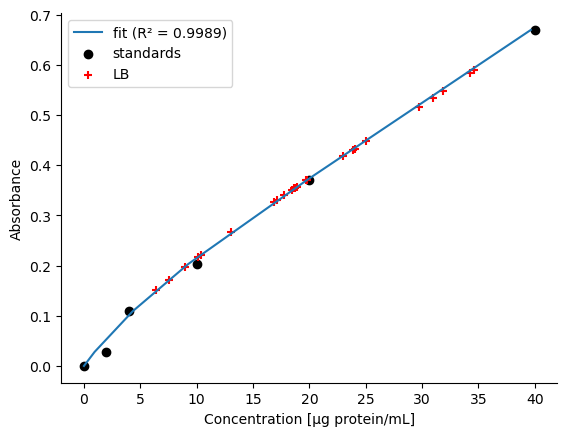

In [112]:
# plot line of best fit and standard data
plt.plot(C_fit, A_std, label = 'fit')       # line of best fit from standard data
plt.scatter(C_std, A_std, c='black', label = 'standard')     # standard data

# Plot unknown data
plt.scatter(C, A, c='red', marker='+', label = 'LB')  # loosely-bound

# axes labels
plt.xlabel("Concentration [\u03bcg protein/mL]")
plt.ylabel("Absorbance")
plt.legend(['fit (R\u00b2 = %.4f)' % R_sq,'standards','LB', 'TB']) 

# remove outer borderI
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f'Std_curve_{input_sheet}.png')

#### Save concentrations

In [123]:
# reshape C_tb to be one row, not one column
if C.shape == (6,):
    C = C.reshape(1, -1)

# Convert 2D arrays to DataFrame and save to Excel
df_C = pd.DataFrame(C)

# Save to Excel file
with pd.ExcelWriter(output_fname) as writer:
    df_C.to_excel(writer, sheet_name = output_sheet_lb)  

print('saved to',output_fname)

saved to BCA_output_091825.xlsx


I take the two Excel output files and combine them into one file (BCA_output.xlsx).

Then, I load that into the next code, Plot_C, to plot the final results.